In [1]:
from dotenv import load_dotenv
from langchain_core.tools import Tool

from agent.tools.browser_use_tool import BrowserUseTool, search_function
from agent.tools.planning_tool import PlanningTool
from agent.utils import ChatOpenRouter
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

load_dotenv()

INFO     [browser_use] BrowserUse logging setup complete with level info
INFO     [root] Anonymized telemetry enabled. See https://docs.browser-use.com/development/telemetry for more information.


True

In [2]:
def make_system_prompt(suffix: str) -> str:
    return f"""You are a helpful AI assistant collaborating with other assistants.
Use the provided tools to progress toward finishing up the task.
If you are unable to fully answer, that's OK—another assistant with different tools will help where you left off.
Execute what you can to make progress.
Once you or any team member have the final answer or deliverable, prefix your response with "FINAL ANSWER" so the team knows to stop.
{suffix}"""


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [3]:
llm = ChatOpenRouter(model_name="openai/gpt-4o-mini-2024-07-18")

planning_tool = PlanningTool()

# Create Langchain tools
planning_tools = [
    Tool(
        name="create_plan",
        func=planning_tool.create_plan,
        description="Create a new plan with a list of steps. **Required:** steps (str, comma separated step contents)"
    ),
    Tool(
        name="update_plan",
        func=planning_tool.update_plan,
        description="Update an existing plan with a new list of steps. **Required:** steps (str, comma separated step contents)"
    ),
    Tool(
        name="update_status",
        func=planning_tool.update_status,
        description="Update the status of plan steps. **Required:** statuses (str, comma separated status in ['not_started', 'in_progress', 'completed'])"
    )
]
# Research agent and node
planning_agent = create_react_agent(
    llm,
    tools=planning_tools,
    prompt=make_system_prompt("""You are an expert Planning Agent tasked with solving problems efficiently through structured plans.
Your job is:
1. Analyze requests to understand the task scope
2. Create a clear, actionable plan that makes meaningful progress with the `planning` tools
3. Track and update progress of current planning step with the `planning` tools
4. Update current plans when necessary with the `planning` tools
5. Use `FINAL ANSWER` to conclude immediately when the task is complete

Based on the current state, what's your next action?
Choose the most efficient path forward:
1. Is the plan sufficient, or does it need refinement?
2. Can you execute the next step immediately?
"""
                              ),
)


def planning_node(
        state: MessagesState,
) -> Command[Literal["browser", END]]:
    result = planning_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "browser")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="planner"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [4]:
import asyncio

browser_tool = BrowserUseTool(llm=llm)

browser_tools = [
    Tool(
        name="Search",
        func=search_function,
        description="Useful for searching the internet for current information."
    ),
    # Tool(
    #     name="Wait",
    #     func=wait,
    #     content="Wait for {input} seconds for other executing actions"
    #
    Tool(
        name="go_to_url",
        func=browser_tool.go_to_url,
        coroutine=browser_tool.a_go_to_url,
        description="Navigate to a specific URL in the browser. **Required:** url (string)."
    ),
    Tool(
        name="go_back",
        func=browser_tool.go_back,
        coroutine=browser_tool.a_go_back,
        description="Navigate back to the previous page. **No additional parameters required.**"
    ),
    Tool(
        name="click_element",
        func=browser_tool.click_element,
        coroutine=browser_tool.a_click_element,
        description="Click an element in the webpage identified by its index. **Required:** index (integer)."
    ),
    Tool(
        name="input_text",
        func=browser_tool.input_text,
        coroutine=browser_tool.a_input_text,
        description="Input text into a form element. **Required:** index (integer), text (string)."
    ),
    
    Tool(
        name="scroll_down",
        func=browser_tool.scroll_down,
        coroutine=browser_tool.a_scroll_down,
        description="Scroll down by a specified amount of pixels. **Required:** scroll_amount (integer)."
    ),
    Tool(
        name="scroll_up",
        func=browser_tool.scroll_up,
        coroutine=browser_tool.a_scroll_up,
        description="Scroll up by a specified amount of pixels. **Required:** scroll_amount (integer)."
    ),
    Tool(
        name="scroll_to_text",
        func=browser_tool.scroll_to_text,
        coroutine=browser_tool.a_scroll_to_text,
        description="Scroll to a specific text on the page. **Required:** text (string)."
    ),
    Tool(
        name="get_dropdown_options",
        func=browser_tool.get_dropdown_options,
        coroutine=browser_tool.a_get_dropdown_options,
        description="Retrieve all dropdown options for a given element. **Required:** index (integer)."
    ),
    Tool(
        name="select_dropdown_option",
        func=browser_tool.select_dropdown_option,
        coroutine=browser_tool.a_select_dropdown_option,
        description="Select a dropdown option based on visible text. **Required:** index (integer), text (string)."
    ),
    Tool(
        name="extract_content",
        func=browser_tool.extract_content,
        coroutine=browser_tool.a_extract_content,
        description="Extract specific information from a webpage. **Required:** goal (string, describing what to extract)."
    ),
    Tool(
        name="get_current_state",
        func=browser_tool.get_current_state,
        coroutine=browser_tool.a_get_current_state,
        description="Retrieve the current browser state. ALWAYS use this tool to get dom element index before using click or dropdown tools. **No additional parameters required.**"
    ),
    Tool(
        name="switch_tab",
        func=browser_tool.switch_tab,
        coroutine=browser_tool.a_switch_tab,
        description="Switch to a specific tab using its ID. **Required:** tab_id (integer)."
    ),
    Tool(
        name="open_tab",
        func=browser_tool.open_tab,
        coroutine=browser_tool.a_open_tab,
        description="Open a new tab with a given URL. **Required:** url (string)."
    ),
    Tool(
        name="close_tab",
        func=browser_tool.close_tab,
        coroutine=browser_tool.a_close_tab,
        description="Close the current tab. **No additional parameters required.**"
    ),
    Tool(
        name="wait",
        func=browser_tool.wait,
        coroutine=browser_tool.a_wait,
        description="Pause execution for a specified duration. **Required:** seconds (integer)."
    )
]

browser_agent = create_react_agent(
    llm,
    browser_tools,
    prompt=make_system_prompt(
        "You are an AI agent designed to automate browser tasks. Your goal is to accomplish the ultimate task"
    ),
)


def browser_node(state: MessagesState) -> Command[Literal["planner", END]]:
    result = asyncio.run(browser_agent.ainvoke(state))
    goto = get_next_node(result["messages"][-1], "planner")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="browser"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [5]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("planner", planning_node)
workflow.add_node("browser", browser_node)

workflow.add_edge(START, "planner")
graph = workflow.compile()

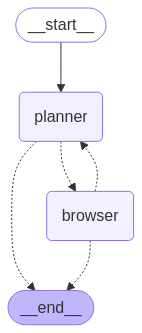

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
inputs = {
        "messages": [
            (
                "user",
                "help me plan a 4 day trip to Tokyo in July this year, the budget is up to 3500 cad",
            )
        ],
    }
async for output in graph.astream(inputs, {"recursion_limit": 50}, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1].pretty_print())
    print("\n---\n")


Output from node 'planner':
---
================================ Human Message =================================
Name: planner

Sorry, need more steps to process this request.
None

---
Output from node 'browser':
---
================================ Human Message =================================
Name: browser

### Tokyo Trip Plan Summary

**Dates**: July 2023  
**Budget**: Up to 3500 CAD

#### Flight Options
- **Departure**: Vancouver (YVR)
- **Arrival**: Tokyo (TYO)
- **Airline**: Japan Airlines (JAL)
- **Trip Type**: Round-trip
- **Duration**: 4 days

**Currently, specific flight prices are unavailable.** It's recommended to check the JAL website or flight aggregators for updates.

#### Hotel Options (for 4 nights)
1. **Villa Fontaine Grand Haneda Airport**
   - **Location**: Ota Ward, Tokyo
   - **Price per Night**: $156.13
   - **Total Cost**: **$624.52**
   - **Rating**: 8.6
   - **[More Info](https://www.booking.com/hotel/jp/villa-fontaine-grand-haneda-airport.html)**

2. **Hot